In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor,CatBoostClassifier,Pool
import matplotlib.pyplot as plt
import re

/Users/david2020/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
%matplotlib notebook

In [3]:
def extract_split_info(source_code,all_feature_map_dict):
    feature_map_dict = {}
    for item in source_code.split('\n'):
        if item.startswith('\t0'):
            if 'label="' in item: 
                item_in = re.search('label=".+?"',item).group(0).replace('"','').replace(' ','')
                feature_map_name, split_v = item_in.split(',')
                feature_map_name = feature_map_name.replace('label=','')
                feature_map_dict[split_v] = {}
            elif item.startswith('\t0 -> 1'):
                item_in = re.search('label=.+?]',item).group(0).replace(']','').replace('label=','')
                left = item_in
                feature_map_dict[split_v][left]=0
            elif item.startswith('\t0 -> 2'):
                item_in = re.search('label=.+?]',item).group(0).replace(']','').replace('label=','')
                right = item_in
                feature_map_dict[split_v][right]=0
        elif item.startswith('\t1'):
            if 'label="' in item:
                aa,item_in = item.split('val = ')
                left_value = float(item_in)
        elif item.startswith('\t2'):
            if 'label="' in item: 
                aa,item_in = item.split('val = ')
                right_value = float(item_in)
    feature_map_dict[split_v][left] = left_value
    feature_map_dict[split_v][right] = right_value
    if feature_map_name not in all_feature_map_dict.keys():
        all_feature_map_dict[feature_map_name] = {}
    all_feature_map_dict[feature_map_name].update(feature_map_dict)
def extract_value(string):
    return(float(string.replace('value>','')))
def extract_value(string):
    return(float(string.replace('value>','')))
def generate_basis(all_feature_map_dict,train_df):
    result_dict = {}
    for key,value in all_feature_map_dict.items():
        result_dict[key] = {}
        splits = train_df[key].sort_values().values
        f_values = np.zeros(splits.shape)
        for key_1, value_1 in value.items():
            spl = float(key_1.replace('value>',''))
            f_values[splits>spl] += value_1['Yes']
            f_values[splits<=spl] += value_1['No']
        result_dict[key]['index'] = splits
        result_dict[key]['value'] = f_values
    return result_dict
def extract_basis_from_catboost(model,pool,train_df):
    all_feature_map_dict = {}
    for ii in range(model.get_param('iterations')):
        source_code = model.plot_tree(ii, pool=pool).source
        extract_split_info(source_code,all_feature_map_dict)
    result_dict = generate_basis(all_feature_map_dict,train_df)
    return result_dict

In [ ]:
dataset = pd.read_csv('data.csv')   

In [183]:
dataset = dataset.set_index(pd.to_datetime(dataset['Unnamed: 0']),drop=True)
feature_list = list(dataset.columns)
# if dataset_name == 'huazhong':
#     feature_list.remove('Unnamed_0')
feature_list.remove('Unnamed: 0')
feature_list.remove('load')

In [185]:
if dataset_name == 'ningbo':
    train_df = dataset[pd.to_datetime('2022-03-01 00:15:00'):pd.to_datetime('2022-07-01 00:15:00')]
    valid_df = dataset[pd.to_datetime('2022-06-01 00:15:00'):pd.to_datetime('2022-07-01 00:15:00')]
    test_df = dataset[pd.to_datetime('2022-07-01 00:15:00'):pd.to_datetime('2022-07-11 00:15:00')]
else:
    train_df = dataset[pd.to_datetime('2020-02-01 00:15:00'):pd.to_datetime('2022-06-01 00:15:00')]
    valid_df = dataset[pd.to_datetime('2022-05-01 00:15:00'):pd.to_datetime('2022-06-01 00:15:00')]
    test_df = dataset[pd.to_datetime('2022-06-01 00:15:00'):pd.to_datetime('2022-07-25 00:15:00')]

In [186]:
train_X = train_df[feature_list].values
train_y = train_df['load'].values
valid_X = valid_df[feature_list].values
valid_y = valid_df['load'].values
test_X = test_df[feature_list].values
test_y = test_df['load'].values

In [187]:
def get_acc(ypred,ytrue):
    acc_day=[]
    for jth in range(len(ytrue)//96):
        acc_day.append(accuracy(ypred[jth*96:(jth+1)*96],ytrue[jth*96:(jth+1)*96]))
    return np.nanmean(acc_day)
def accuracy(ypred,ytrue): 
    if ytrue.size != ypred.size:
        raise ValueError('Incompatible size!')
    
    elif ytrue.size == 0:
        return 0
    else:
        return 1 - np.sqrt(np.nanmean(((ytrue - ypred) / ytrue) ** 2))

In [188]:
model = CatBoostRegressor(learning_rate=0.01, depth=1, verbose=5000, loss_function='MAE',iterations=20000)
# model = CatBoostRegressor(learning_rate=0.3, depth=1, verbose=5000, loss_function='RMSE',iterations=20000)
fit_model = model.fit(train_X, train_y)
pred_y = model.predict(test_X)
print(get_acc(pred_y,test_y))
dataset['gam_predicted'] = model.predict(dataset[feature_list].values)
if dataset_name == 'ningbo':
    dataset.to_csv(dataset_name+'_20220202_20220712_features_gam.csv')
else:
    dataset.to_csv(dataset_name+'_20200209_20220725_features_gam.csv')

0:	learn: 300.6982653	total: 8.45ms	remaining: 2m 48s
5000:	learn: 67.0598695	total: 41.9s	remaining: 2m 5s
10000:	learn: 63.8343068	total: 1m 22s	remaining: 1m 22s
15000:	learn: 62.0810010	total: 1m 58s	remaining: 39.6s
19999:	learn: 60.9183413	total: 2m 34s	remaining: 0us
0.9424766558704126


<IPython.core.display.Javascript object>


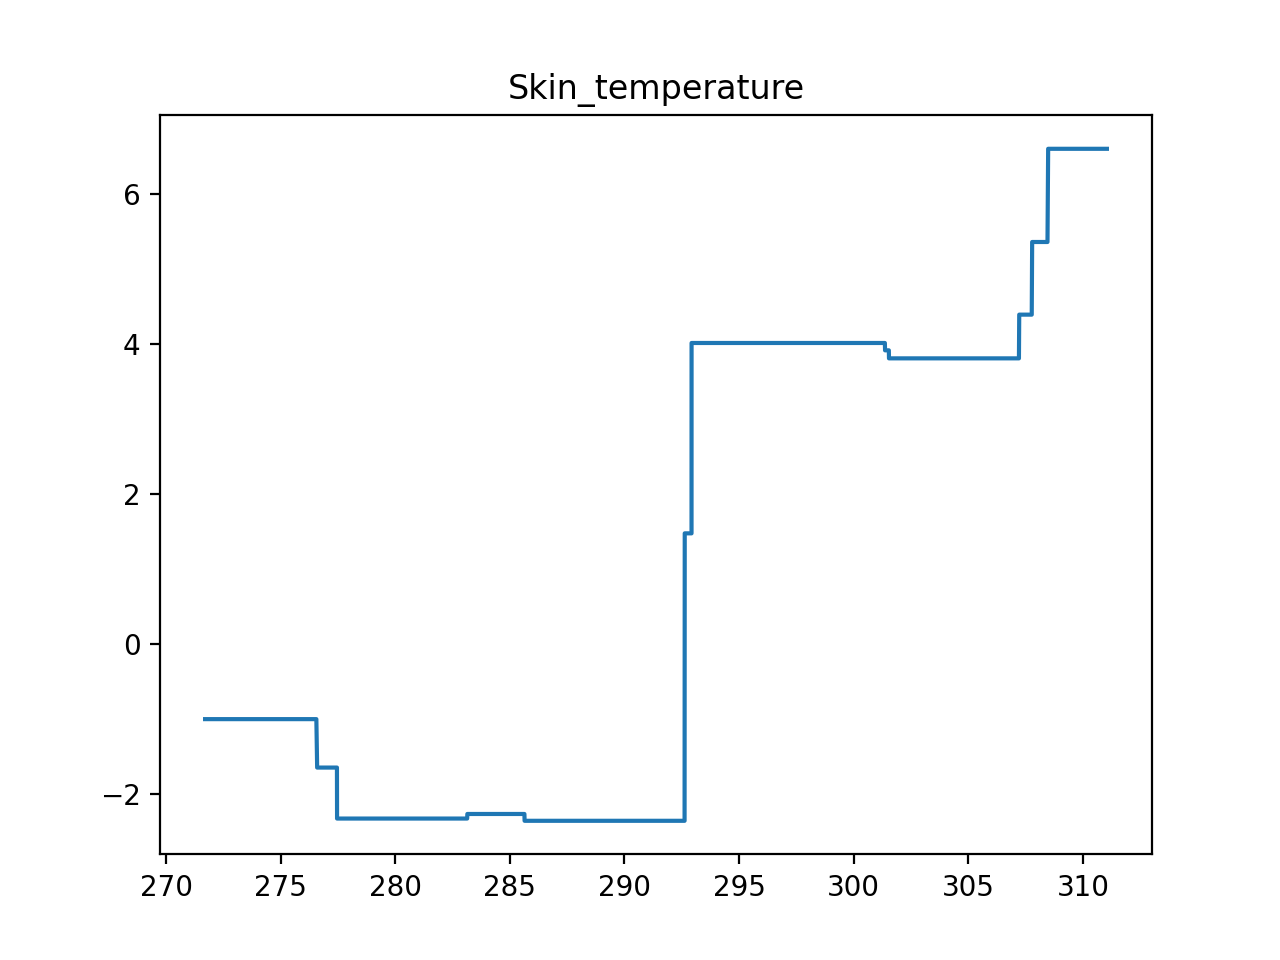

<IPython.core.display.Javascript object>


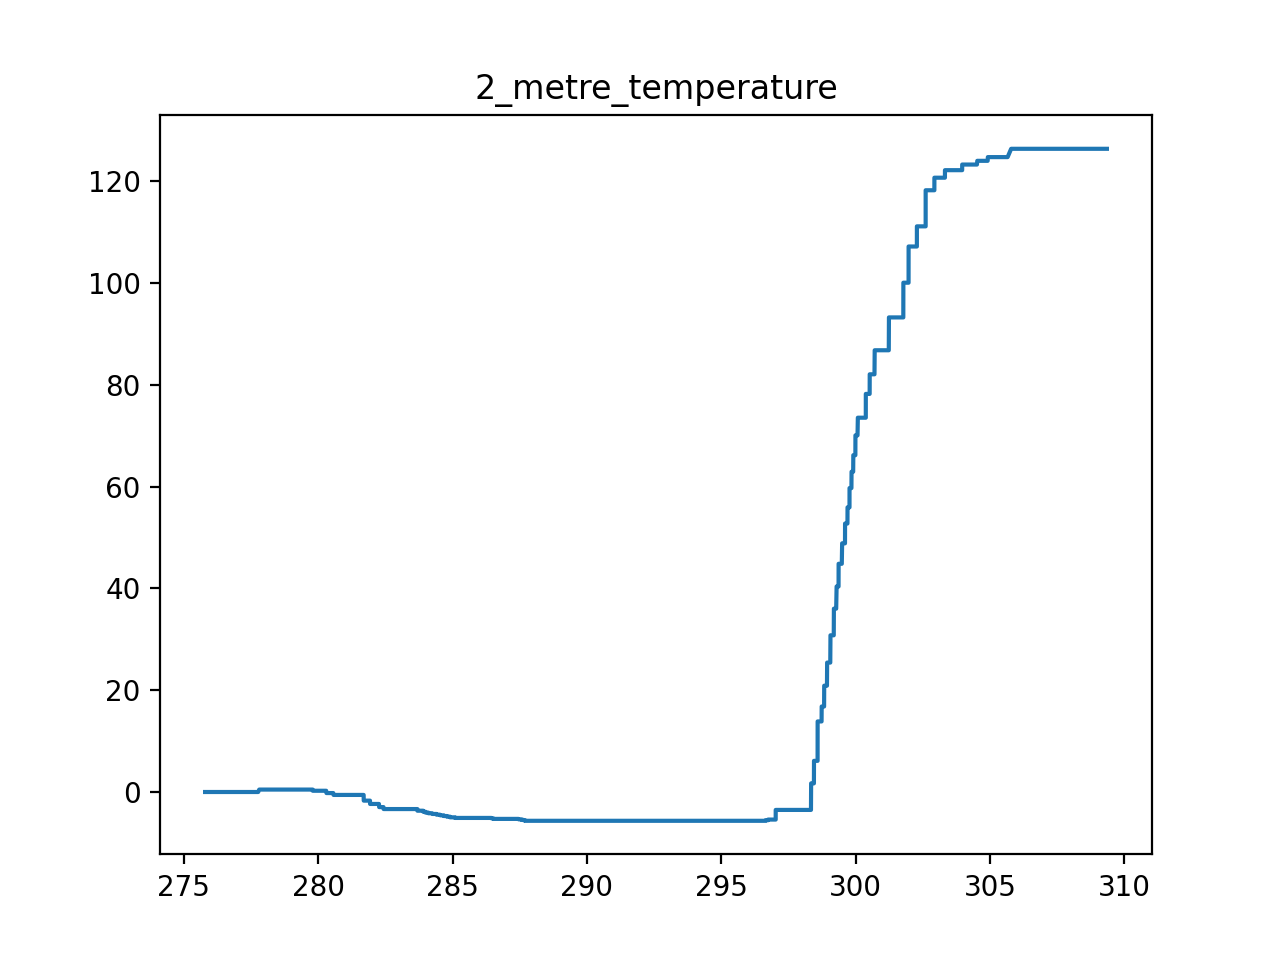

<IPython.core.display.Javascript object>


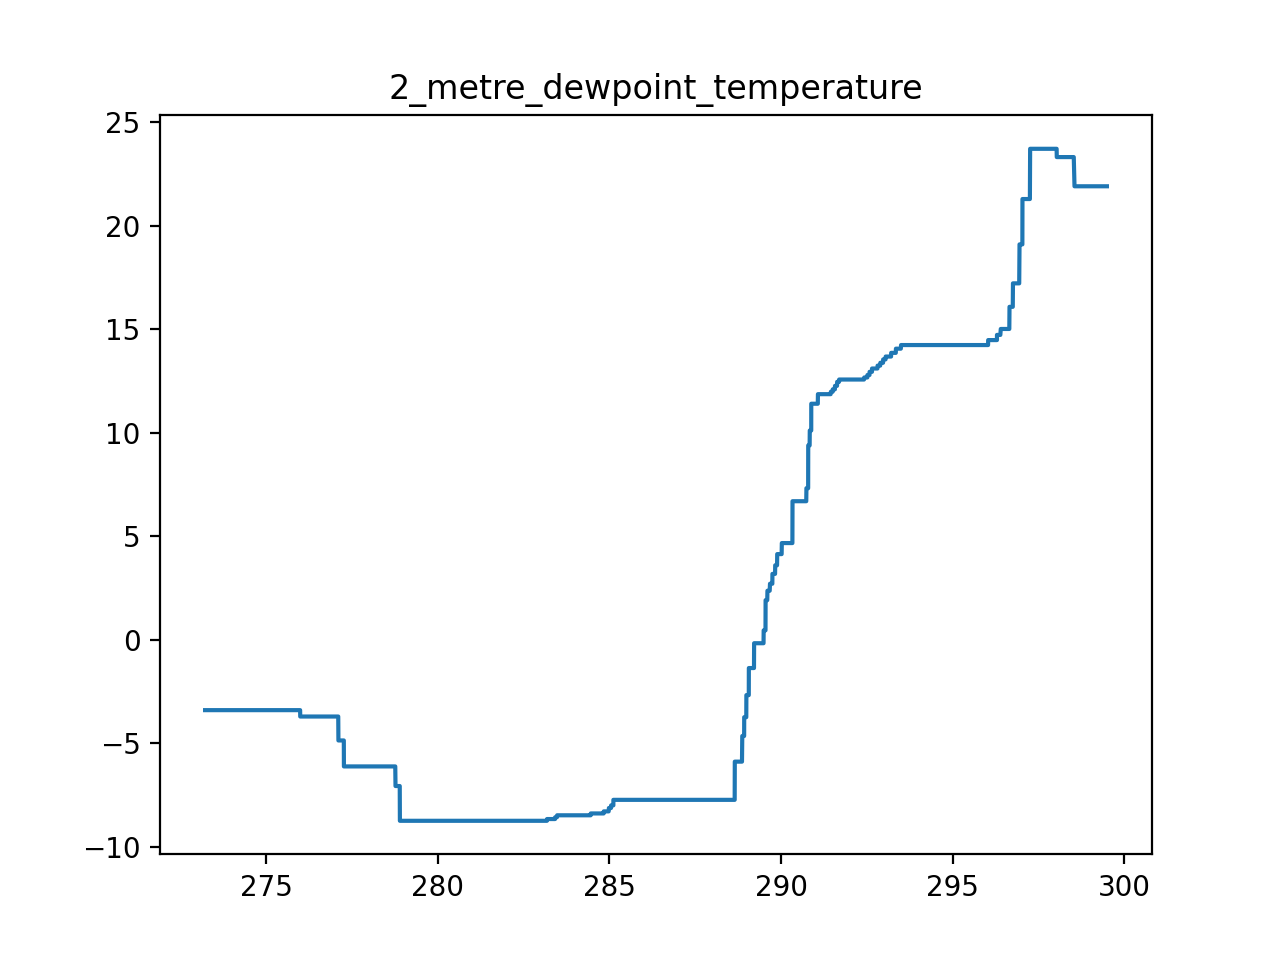

<IPython.core.display.Javascript object>


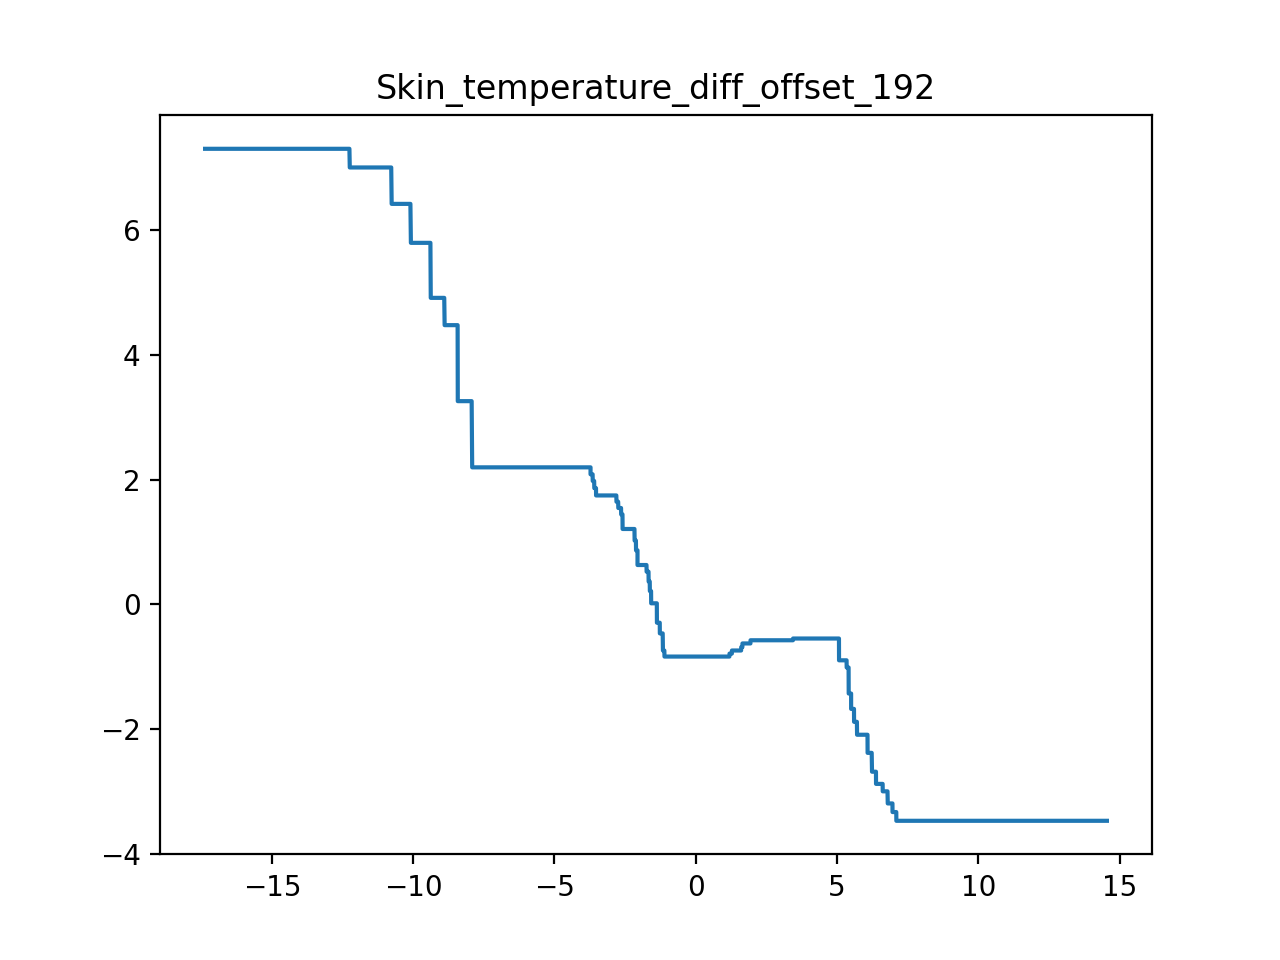

In [141]:
pool = Pool(train_X,train_y,feature_names=feature_list)
result_dict = extract_basis_from_catboost(model,pool,train_df)
for key,val in result_dict.items():
    if 'temperature' not in key:
        continue
    plt.figure()
    plt.plot(val['index'],val['value'])
    plt.show()
    plt.title(key)